# Final Project

- Saige Belanger
    - (20951877)
- Dylan Faelker
    - (20960747)
- Ethan Liu
    - (20959615)
- Timothy Zheng
    - t54zheng (20939203)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
from sklearn import linear_model
import statsmodels.api as sm
import scipy.stats as stats
from math import sqrt
import math

from sklearn import preprocessing
from sklearn.impute import SimpleImputer
import datetime as dt

import os.path

warnings.filterwarnings('ignore')

# Factors
We start with an initial list of factors from the provided list of 50 Factors in the ML examples.

TODO: Increase our breadth of factors to the category chosen by downloading and creating them, then merging them 

https://wrds-www.wharton.upenn.edu/pages/get-data/compustat-capital-iq-standard-poors/compustat/north-america-daily/fundamentals-quarterly/

In [2]:
all_monthly_data = pd.read_sas("merged_df.sas7bdat", encoding = 'ISO-8859-1')

In [3]:
# Save all gvkeys - for WRDS Queries

# with open("gvkeys.txt", "w") as file:
#     for gvkey in set(all_monthly_data["gvkey"].dropna()):
#         file.write(f"{int(gvkey)},\n")

In [4]:
permnos = set(all_monthly_data["permno"])

In [5]:
gvkey_permno_dict = {}
for gvkey in set(all_monthly_data["gvkey"].dropna()):
    permno = all_monthly_data[all_monthly_data["gvkey"] == gvkey]["permno"].dropna().iloc[0]
    gvkey_permno_dict[gvkey] = permno

In [6]:
all_monthly_data.drop(["ticker", "conm", "gvkey", "cusip", "naics", "gsubind"], axis=1, inplace=True) # We don't use these columns anyway, drop them

In [7]:
factors = ['IM', 'range_20', 'log_vol_dollar_20',
       'range_120', 'log_vol_dollar_120', 'xret_5', 'xret_10', 'xret_20',
       'xret_indsize_20', 'xret_indsize_std20', 'xret_40', 'xret_120',
       'xret_indsize_120', 'xret_indsize_std120', 'KDJ_20', 'deviation_pct20',
       'MoneyFlowIndex_20', 'RSI_20', 'KDJ_120', 'deviation_pct120',
       'MoneyFlowIndex_120', 'RSI_120', 'IV_capm', 'mdr', 'ami_3', 'beta_3y',
       'beta_5y', 'tail_2y', 'dp', 'leverage', 'BL', 'roe', 'roa',
       'profitability', 'sales_g_q', 'sales_g_ttm', 'op_income_g_q', 'ni_g_q',
       'op_income_g_ttm', 'ni_g_ttm', 'sue_NI', 'BM', 'AM', 'EP', 'SP',
       'roe_q', 'roa_q', 'Cto', 'pe_ttm', 'lag_log_size']

ret_cols = ['ret_f1', 'ret_f2', 'ret_f3', 'ret_f4', 'ret_f5', 'ret_f6', 
            'ret_f7', 'ret_f8', 'ret_f9', 'ret_f10', 'ret_f11', 'ret_f12']

In [8]:
non_data_cols = [x for x in all_monthly_data.columns if x not in factors and x not in ret_cols]
non_data_cols

['permno', 'yyyymm', 'monthid', 'PRC', 'VOL', 'RET', 'SHROUT']

# Adding New Factors
* When you add a factor, document it here: [link](https://docs.google.com/spreadsheets/d/1rs9633QSYLVY5Z5DoGNy3USP2MROGtqTIKcbLG68wpE/edit#gid=1579135478) and fill properly
* Download the data file, if it's too large add it to the drive
* Also download the other files that arent on github but on the drive before working on this part of the notebook
    * https://drive.google.com/drive/u/0/folders/1D1eIYlkNxNLfzHJLzkGeE9ymr7doXg_6

## IMPORTANT NOTE - FACTOR/RETURN TIME
- When adding factors make sure you add such that factor is reported at t-1, **RET** has **T** returns (in same row)
- This means you need to download data from the range **(1979-12 to 2019-11)**

***

- Treasury and CPI Rates: [Link](https://wrds-www.wharton.upenn.edu/pages/get-data/center-research-security-prices-crsp/annual-update/index-treasury-and-inflation/us-treasury-and-inflation-indexes/)
- Federal Reserve Data: [Link](https://wrds-www.wharton.upenn.edu/pages/get-data/federal-reserve-bank-reports/interest-rates/data/)
- SEC Filings: https://wrds-www.wharton.upenn.edu/pages/get-data/wrds-sec-analytics-suite/wrds-sec-filings-queries/list-of-filings-exhibits/
- Analyzed Data: https://wrds-www.wharton.upenn.edu/pages/get-data/wrds-sec-analytics-suite/wrds-sec-text-analysis/readability-and-sentiment/

**TBD**
- Other Factors: Downloaded from https://wrds-www.wharton.upenn.edu/pages/get-data/compustat-capital-iq-standard-poors/compustat/north-america-daily/fundamentals-quarterly/

In [9]:
# Add new generated factors here
recession_factors = ["10M2", "volinc", "recession_affinity"]
tone_factors = ['10Q_tone_3m', '10Q_tone_6m', 
                '10K_tone_1y', 
                '8K_tone_1y',]
factors += recession_factors
factors += tone_factors

# SEC Filings Sentiment Factors

In [10]:
sec_analytics = pd.read_sas("sec_filing_analysis_wrds.sas7bdat", encoding = 'ISO-8859-1')

In [11]:
sec_analytics["PERMNO"] = sec_analytics["GVKEY"].map(gvkey_permno_dict)

In [12]:
# Import from Dylan's code
sec_analytics['yyyymm'] = (sec_analytics['FDATE'].astype('string').str[:4] + sec_analytics['FDATE'].astype('string').str[5:7]).astype('float64')
sec_analytics_subset_forms = sec_analytics[(sec_analytics['FORM'].isin(['10-K', '10-Q', '8-K']))][["PERMNO", "yyyymm", "FORM", "LM_POSITIVE_COUNT", "LM_NEGATIVE_COUNT", "WORD_COUNT"]]

sec_analytics_subset_forms['tone'] = (sec_analytics_subset_forms['LM_POSITIVE_COUNT'] - sec_analytics_subset_forms['LM_NEGATIVE_COUNT']) / sec_analytics_subset_forms['WORD_COUNT']

sec_analytics_subset_forms.head()

,PERMNO,yyyymm,FORM,LM_POSITIVE_COUNT,LM_NEGATIVE_COUNT,WORD_COUNT,tone
0,86594.0,201306.0,10-K,2387.0,2500.0,260142.0,-0.000434
9,86594.0,200703.0,10-Q,110.0,115.0,14978.0,-0.000334
11,86594.0,201209.0,8-K,35.0,31.0,3111.0,0.001286
14,86594.0,200502.0,8-K,279.0,931.0,53640.0,-0.012155
17,86594.0,200606.0,8-K,15.0,6.0,907.0,0.009923


In [13]:

def yyyymm_add(yyyymm, years, months):
    return yyyymm + ((years + math.floor(months / 12)) * 100) + (months % 12)

def yyyymm_sub(yyyymm, years, months):
    return yyyymm - ((years + math.floor(months / 12)) * 100) - (months % 12)

In [14]:
!pip install multiprocess

In [15]:
from multiprocess import cpu_count # You might have to change to multiprocessing if on windows
from multiprocess.pool import ThreadPool

In [ ]:
# Threaded Approach. Takes estimate >2h
def calc_tone_factors(permno):
    results = []

    for date in all_monthly_data['yyyymm'].unique():
        sentiments = {}
        # when there is no relevant data. Saves time
        if sec_analytics_subset_forms.loc[(permno == sec_analytics_subset_forms['PERMNO']) & (date > sec_analytics_subset_forms['yyyymm']) & (date <= yyyymm_add(sec_analytics_subset_forms['yyyymm'], 1, 0))].shape[0] == 0:
            sentiments = {"permno": permno, 
                            "yyyymm": date,
                            '10Q_tone_3m': 0,
                            '10Q_tone_6m': 0,
                            '10K_tone_1y': 0,
                            '8K_tone_1y': 0,
                            }
        elif sec_analytics_subset_forms.loc[(permno == sec_analytics_subset_forms['PERMNO']) & (date > sec_analytics_subset_forms['yyyymm']) & (date <= yyyymm_add(sec_analytics_subset_forms['yyyymm'], 0, 6))].shape[0] == 0:
            sentiments = {"permno": permno, 
                            "yyyymm": date,
                            '10Q_tone_3m': 0,
                            '10Q_tone_6m': 0,
                            '10K_tone_1y': sec_analytics_subset_forms.loc[('10-K' == sec_analytics_subset_forms['FORM']) & (permno == sec_analytics_subset_forms['PERMNO']) & (date > sec_analytics_subset_forms['yyyymm']) & (date <= yyyymm_add(sec_analytics_subset_forms['yyyymm'], 1, 0)), 'tone'].sum(),
                            '8K_tone_1y': sec_analytics_subset_forms.loc[('8-K' == sec_analytics_subset_forms['FORM']) & (permno == sec_analytics_subset_forms['PERMNO']) & (date > sec_analytics_subset_forms['yyyymm']) & (date <= yyyymm_add(sec_analytics_subset_forms['yyyymm'], 1, 0)), 'tone'].sum(),
                            }
        elif sec_analytics_subset_forms.loc[(permno == sec_analytics_subset_forms['PERMNO']) & (date > sec_analytics_subset_forms['yyyymm']) & (date <= yyyymm_add(sec_analytics_subset_forms['yyyymm'], 0, 3))].shape[0] == 0:
            sentiments = {"permno": permno, 
                            "yyyymm": date,
                            '10Q_tone_3m': 0,
                            '10Q_tone_6m': sec_analytics_subset_forms.loc[('10-Q' == sec_analytics_subset_forms['FORM']) & (permno == sec_analytics_subset_forms['PERMNO']) & (date > sec_analytics_subset_forms['yyyymm']) & (date <= yyyymm_add(sec_analytics_subset_forms['yyyymm'], 0, 6)), 'tone'].sum(),
                            '10K_tone_1y': sec_analytics_subset_forms.loc[('10-K' == sec_analytics_subset_forms['FORM']) & (permno == sec_analytics_subset_forms['PERMNO']) & (date > sec_analytics_subset_forms['yyyymm']) & (date <= yyyymm_add(sec_analytics_subset_forms['yyyymm'], 1, 0)), 'tone'].sum(),
                            '8K_tone_1y': sec_analytics_subset_forms.loc[('8-K' == sec_analytics_subset_forms['FORM']) & (permno == sec_analytics_subset_forms['PERMNO']) & (date > sec_analytics_subset_forms['yyyymm']) & (date <= yyyymm_add(sec_analytics_subset_forms['yyyymm'], 1, 0)), 'tone'].sum(),
                            }
        else:
            sentiments = {"permno": permno, 
                            "yyyymm": date,
                            '10Q_tone_3m': sec_analytics_subset_forms.loc[('10-Q' == sec_analytics_subset_forms['FORM']) & (permno == sec_analytics_subset_forms['PERMNO']) & (date > sec_analytics_subset_forms['yyyymm']) & (date <= yyyymm_add(sec_analytics_subset_forms['yyyymm'], 0, 3)), 'tone'].sum(),
                            '10Q_tone_6m': sec_analytics_subset_forms.loc[('10-Q' == sec_analytics_subset_forms['FORM']) & (permno == sec_analytics_subset_forms['PERMNO']) & (date > sec_analytics_subset_forms['yyyymm']) & (date <= yyyymm_add(sec_analytics_subset_forms['yyyymm'], 0, 6)), 'tone'].sum(),
                            '10K_tone_1y': sec_analytics_subset_forms.loc[('10-K' == sec_analytics_subset_forms['FORM']) & (permno == sec_analytics_subset_forms['PERMNO']) & (date > sec_analytics_subset_forms['yyyymm']) & (date <= yyyymm_add(sec_analytics_subset_forms['yyyymm'], 1, 0)), 'tone'].sum(),
                            '8K_tone_1y': sec_analytics_subset_forms.loc[('8-K' == sec_analytics_subset_forms['FORM']) & (permno == sec_analytics_subset_forms['PERMNO']) & (date > sec_analytics_subset_forms['yyyymm']) & (date <= yyyymm_add(sec_analytics_subset_forms['yyyymm'], 1, 0)), 'tone'].sum(),
                            }
        results.append(sentiments)
    
    return results

permnos = set(all_monthly_data["permno"])
with ThreadPool(cpu_count() - 1) as P:
    sentiments = P.map(calc_tone_factors, permnos)
    sentiments = [item for sublist in sentiments for item in sublist]
    sentiments = pd.DataFrame(sentiments)
    all_monthly_data = pd.merge(all_monthly_data, sentiments, on=["permno", "yyyymm"], how='outer')

In [ ]:
all_monthly_data[all_monthly_data["permno"] == 86594.0].sort_values(by="monthid").head()

,permno,yyyymm,monthid,IM,range_20,log_vol_dollar_20,range_120,log_vol_dollar_120,xret_5,xret_10,...,ret_f7,ret_f8,ret_f9,ret_f10,ret_f11,ret_f12,10Q_tone_3m,10Q_tone_6m,10K_tone_1y,8K_tone_1y
578148,86594.0,199901.0,229.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.223744,0.376866,-0.035230,0.016854,0.607735,-0.053265,0.000000,0.000000,0.0,0.000000
578149,86594.0,199902.0,230.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.376866,-0.035230,0.016854,0.607735,-0.053265,0.088929,0.000000,0.000000,0.0,0.000000
578150,86594.0,199903.0,231.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.035230,0.016854,0.607735,-0.053265,0.088929,-0.206667,0.000000,0.000000,0.0,-0.023482
578151,86594.0,199904.0,232.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.016854,0.607735,-0.053265,0.088929,-0.206667,-0.109244,0.000887,0.000887,0.0,-0.023482
578152,86594.0,199905.0,233.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.607735,-0.053265,0.088929,-0.206667,-0.109244,-0.183962,0.000887,0.000887,0.0,-0.023482


# Recession Factor
- During recessions, companies that sell essential products/services typically outperform companies that offer products that are categorized as discretionary spending by consumers.
- Basically we want to come up with a factor such that during recessions, the factor is high for companies selling essential products/services and low for companies producing goods/services that are highly sensitive to recessions. Then we want the factor to be flipped when the company is out of a recession.
- We will categorize a recession as whenever the yield curve is inverted

### Proxy factors
- [10M2] Yield curve: US Treasury 10Y - US Treasury 2 Year: https://fred.stlouisfed.org/series/T10Y2YM
    - Recession if 10M2 < 0 [inverted yield curve]

- [volinc] Annual Income Volatility: Standard Deviation of annual net income growth [ni_g_ttm] for past 5 years, minimum past 1 year
    - Using trailing twelve month (TTM) measure because it avoids any seasonality considerations

In [16]:
all_monthly_data[all_monthly_data["permno"] == 86594.0][["ni_g_ttm", "yyyymm"]].dropna().head(12)

,ni_g_ttm,yyyymm
382792,-0.319421,200001.0
382793,-0.319421,200002.0
382794,-0.319421,200003.0
382795,-0.298619,200004.0
382796,-0.298619,200005.0
382797,-0.298619,200006.0
382798,0.319728,200007.0
382799,0.319728,200008.0
382800,0.319728,200009.0
382801,0.334539,200010.0


In [17]:
# Add annual income volatility - std of ni_g_ttm for past 5 years, minimum of past 1 year

volinc = {"yyyymm": [], "permno": [], "volinc": []}
for permno in permnos:
    ni_g_ttm = all_monthly_data[all_monthly_data["permno"] == permno][["ni_g_ttm", "yyyymm"]].dropna()
    date_range = sorted(list(ni_g_ttm["yyyymm"]))

    for i, yyyymm in enumerate(date_range):
        
        window = set(date_range[max(0, i-59):i+1]) # Look past 5 years (60 months)
        window_data = ni_g_ttm[ni_g_ttm["yyyymm"].isin(window)]
        
        if len(window_data) < 12:
            continue

        # Add std ni_g_ttm of past 5 years to volinc factor
        # Note this avoids lookahead bias because the data up to and including i
        # should be known (since ni_g_ttm is from i-1 as per data manual)
        volinc["yyyymm"].append(yyyymm)
        volinc["permno"].append(permno)
        volinc["volinc"].append(window_data["ni_g_ttm"].std())

volinc_df = pd.DataFrame(volinc)
volinc_df.head()

,yyyymm,permno,volinc
0,198012.0,49154.0,0.023537
1,198101.0,49154.0,0.024160
2,198102.0,49154.0,0.024472
3,198103.0,49154.0,0.024585
4,198104.0,49154.0,0.023754


In [18]:
all_monthly_data = pd.merge(all_monthly_data, volinc_df, on=["yyyymm", "permno"], how="outer")

## 10M2 Yield Curve

In [19]:
treasury_inflation = pd.read_sas("treasury_inflation.sas7bdat", encoding = 'ISO-8859-1')

In [20]:
fact_10M2 = treasury_inflation[["CALDT", "B2RET", "B10RET"]]

# Add one month to fit RET and factor time
fact_10M2["yyyymm"] = (fact_10M2["CALDT"] + pd.DateOffset(months=1)).dt.strftime("%Y%m").astype(float)

In [21]:
fact_10M2["10M2"] = fact_10M2["B10RET"] - fact_10M2["B2RET"]
fact_10M2

,CALDT,B2RET,B10RET,yyyymm,10M2
0,1979-12-31,0.005695,0.011951,198001.0,0.006256
1,1980-01-31,-0.000164,-0.037477,198002.0,-0.037313
2,1980-02-29,-0.036947,-0.050507,198003.0,-0.013560
3,1980-03-31,0.010329,0.048345,198004.0,0.038016
4,1980-04-30,0.084198,0.084375,198005.0,0.000177
...,...,...,...,...,...
477,2019-09-30,-0.001297,-0.013852,201910.0,-0.012555
478,2019-10-31,0.003274,-0.000742,201911.0,-0.004016
479,2019-11-29,-0.001038,-0.007410,201912.0,-0.006372
480,2019-12-31,0.002274,-0.011292,202001.0,-0.013566


In [22]:
all_monthly_data = pd.merge(all_monthly_data, fact_10M2[["yyyymm", "10M2"]], on="yyyymm")

## Recession Affinity
* Recession affinity is calculated as

- 1 / volinc **if 10M2 < 0** (recession)
- volinc $\times$ 1500 **if 10M2 > 0** (no recession)
    - TBH Times 1500 descision is arbitrary but it makes sense in "levelling" both sides of the variable, ie:
    - Values when 10M2 < 0 and 10M2 > 0 are relatively equal

In [ ]:
all_monthly_data["recession_affinity"] = np.where(all_monthly_data["10M2"] < 0, 1 / all_monthly_data["volinc"], 1500 * all_monthly_data["volinc"])

In [ ]:
test = all_monthly_data[["10M2", "volinc", "recession_affinity"]].dropna()

In [ ]:
test[test["10M2"] < 0]["recession_affinity"].mean()

105.45824976257666

In [ ]:
test[test["10M2"] > 0]["recession_affinity"].mean()

78.82993778650686

In [ ]:
all_monthly_data

,permno,yyyymm,monthid,IM,range_20,log_vol_dollar_20,range_120,log_vol_dollar_120,xret_5,xret_10,...,ret_f10,ret_f11,ret_f12,10Q_tone_3m,10Q_tone_6m,10K_tone_1y,8K_tone_1y,volinc,10M2,recession_affinity
0,10026.0,198001.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,NaN,0.006256,NaN
1,10032.0,198001.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,NaN,0.006256,NaN
2,10051.0,198001.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,NaN,0.006256,NaN
3,10104.0,198001.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,NaN,0.006256,NaN
4,10107.0,198001.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,NaN,0.006256,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
718555,93374.0,201912.0,480.0,-0.147586,0.010868,17.310472,0.015246,17.388666,0.000246,-0.019599,...,-0.124141,0.086342,0.075351,-0.010593,-0.020941,-0.011014,-0.068925,0.008777,-0.006372,113.930650
718556,93419.0,201912.0,480.0,-0.147586,0.012941,16.775314,0.015804,16.961089,0.008011,0.004462,...,-0.121751,0.349948,-0.066538,-0.001085,-0.003564,-0.002398,-0.050815,0.010539,-0.006372,94.884444
718557,93422.0,201912.0,480.0,-0.046054,0.059361,16.763782,0.067228,17.048398,0.015794,-0.033674,...,-0.003102,0.788889,0.484472,-0.018540,-0.037721,-0.017328,-0.178637,0.125235,-0.006372,7.984961
718558,93427.0,201912.0,480.0,0.260954,0.025465,16.473392,0.028009,16.544964,-0.005524,-0.006388,...,-0.047755,0.138121,0.135851,-0.005819,-0.005819,-0.004089,-0.018317,0.016243,-0.006372,61.566110


***
# Data Cleanup
Done creating all factors, will clean up data before training step 

In [ ]:
# Inputation - as in ML Lecture 1

# Drop NA in all non-numerical columns
all_monthly_data.dropna(subset=non_data_cols, inplace=True)

grouped_med = all_monthly_data.groupby(by='monthid')
# the lambda function gets the median per group in the groupby object, and fills the NaN values with the median per group
imputed_grouped = grouped_med.transform(lambda y: y.fillna(y.median()))

# This line assigns the values of the medians 
all_monthly_data = all_monthly_data.assign(**imputed_grouped.to_dict(orient='series'))
all_monthly_data.dropna(inplace=True)

In [ ]:
# Filtering data by min price and min market share for each year

# Commenting out for runtime - **does not drop any rows**

# all_monthly_data['yyyy'] = all_monthly_data['yyyymm'].astype(str).str[:4]
# all_monthly_data['MKTSHR'] = all_monthly_data['PRC'] * all_monthly_data['SHROUT'] * 1_000

# to_drop_indices = []

# for permno in all_monthly_data.permno.unique():
#     for year in all_monthly_data['yyyy'].unique():
#         mask = (all_monthly_data['permno'] == permno) & (all_monthly_data['yyyy'] == year)
#         if all_monthly_data[mask].shape[0] != 0 != 0 and (all_monthly_data[mask]['MKTSHR'].iloc[0] < 100_000_000 or all_monthly_data[mask]['PRC'].iloc[0] <= 5):
#             to_drop_indices += list(all_monthly_data[mask].index)
# all_monthly_data.drop(to_drop_indices, inplace=True)

In [ ]:
# Winsorizing factors--should winsorize the variables by quarter
for column in factors:
    for date in set(list(all_monthly_data["monthid"])):
        mask = (all_monthly_data["monthid"] == date)
        
        std = all_monthly_data[column][mask].std()
        mean = all_monthly_data[column][mask].mean()

        upper = mean + 3 * std
        lower = mean - 3 * std
        
        all_monthly_data[column][mask].clip(lower, upper, inplace= True)

In [ ]:
all_monthly_data

,permno,yyyymm,monthid,IM,range_20,log_vol_dollar_20,range_120,log_vol_dollar_120,xret_5,xret_10,...,ret_f10,ret_f11,ret_f12,10Q_tone_3m,10Q_tone_6m,10K_tone_1y,8K_tone_1y,volinc,10M2,recession_affinity
16474,10145.0,198012.0,12.0,0.374586,0.027456,15.617313,0.022920,15.145167,-0.045500,-0.051723,...,0.141141,0.002105,-0.066489,0.000000,0.000000,0.000000,0.000000,0.040110,0.013658,60.164922
16476,10241.0,198012.0,12.0,0.188068,0.018115,13.277532,0.019202,13.227823,-0.033571,-0.063374,...,0.152756,-0.034843,-0.007220,0.000000,0.000000,0.000000,0.000000,0.009316,0.013658,13.974516
16486,10460.0,198012.0,12.0,0.324759,0.036155,13.062007,0.027327,12.680238,0.077472,0.109122,...,0.106796,0.093860,0.085020,0.000000,0.000000,0.000000,0.000000,0.007682,0.013658,11.523463
16489,10516.0,198012.0,12.0,0.170149,0.031346,15.249913,0.031163,15.026468,-0.048646,-0.008587,...,0.079316,0.087302,0.124088,0.000000,0.000000,0.000000,0.000000,0.014242,0.013658,21.362453
16500,10866.0,198012.0,12.0,0.273820,0.008009,11.612416,0.013282,11.810300,0.002714,-0.027249,...,0.049107,0.004255,-0.023220,0.000000,0.000000,0.000000,0.000000,0.002783,0.013658,4.174269
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
718555,93374.0,201912.0,480.0,-0.147586,0.010868,17.310472,0.015246,17.388666,0.000246,-0.019599,...,-0.124141,0.086342,0.075351,-0.010593,-0.020941,-0.011014,-0.068925,0.008777,-0.006372,113.930650
718556,93419.0,201912.0,480.0,-0.147586,0.012941,16.775314,0.015804,16.961089,0.008011,0.004462,...,-0.121751,0.349948,-0.066538,-0.001085,-0.003564,-0.002398,-0.050815,0.010539,-0.006372,94.884444
718557,93422.0,201912.0,480.0,-0.046054,0.059361,16.763782,0.067228,17.048398,0.015794,-0.033674,...,-0.003102,0.788889,0.484472,-0.018540,-0.037721,-0.017328,-0.178637,0.125235,-0.006372,7.984961
718558,93427.0,201912.0,480.0,0.260954,0.025465,16.473392,0.028009,16.544964,-0.005524,-0.006388,...,-0.047755,0.138121,0.135851,-0.005819,-0.005819,-0.004089,-0.018317,0.016243,-0.006372,61.566110


## Factor Code

In [23]:
ff4_factors = pd.read_sas("ff4_factors.sas7bdat", encoding = 'ISO-8859-1')
ff4_factors["monthid"] = ff4_factors.index + 1
ff4_factors.head()

,DATEFF,SMB,HML,MKTRF,RF,UMD,monthid
0,1980-01-31,0.0162,0.0175,0.0551,0.0080,0.0755,1
1,1980-02-29,-0.0185,0.0061,-0.0122,0.0089,0.0788,2
2,1980-03-31,-0.0664,-0.0101,-0.1290,0.0121,-0.0955,3
3,1980-04-30,0.0105,0.0106,0.0397,0.0126,-0.0043,4
4,1980-05-30,0.0213,0.0038,0.0526,0.0081,-0.0112,5


In [24]:
dates = [int(x) for x in sorted(list(set(list(all_monthly_data["yyyymm"]))))]
dates[0], dates[-1]

(198001, 201912)

In [25]:
monthids = [int(x) for x in sorted(list(set(list(all_monthly_data["monthid"]))))]
monthids[0], monthids[-1], len(monthids)

(1, 480, 480)

In [26]:
testing_range = monthids[0:2*(len(monthids) // 3)]
validation_range = monthids[2 * len(monthids) // 3:]

# Validate that ranges have correct ratios
len(testing_range) / len(monthids), len(validation_range) / len(monthids), len(testing_range) + len(validation_range)

(0.6666666666666666, 0.3333333333333333, 480)

## Testing Factors

In [28]:
model_factors = ['IM', 'range_20', 'log_vol_dollar_20',
       'range_120', 'log_vol_dollar_120', 'xret_5', 'xret_10', 'xret_20',
       'xret_indsize_20', 'xret_indsize_std20', 'xret_40', 'xret_120',
       'xret_indsize_120', 'xret_indsize_std120', 'KDJ_20', 'deviation_pct20',
       'MoneyFlowIndex_20', 'RSI_20', 'KDJ_120', 'deviation_pct120',
       'MoneyFlowIndex_120', 'RSI_120', 'IV_capm', 'mdr', 'ami_3', 'beta_3y',
       'beta_5y', 'tail_2y', 'dp', 'leverage', 'BL', 'roe', 'roa',
       'profitability', 'sales_g_q', 'sales_g_ttm', 'op_income_g_q', 'ni_g_q',
       'op_income_g_ttm', 'ni_g_ttm', 'sue_NI', 'BM', 'AM', 'EP', 'SP',
       'roe_q', 'roa_q', 'Cto', 'pe_ttm', 'lag_log_size']

In [29]:
model_factors += recession_factors
model_factors += tone_factors

In [30]:
all_monthly_data = pd.merge(ff4_factors, all_monthly_data, on="monthid")

In [31]:
all_monthly_data[["monthid", "permno"] + model_factors[::-1]]

,monthid,permno,8K_tone_1y,10K_tone_1y,10Q_tone_6m,10Q_tone_3m,recession_affinity,volinc,10M2,lag_log_size,...,xret_indsize_std20,xret_indsize_20,xret_20,xret_10,xret_5,log_vol_dollar_120,range_120,log_vol_dollar_20,range_20,IM
0,12,10145.0,0.000000,0.000000,0.000000,0.000000,60.164922,0.040110,0.013658,7.566481,...,0.024948,-0.103709,-0.032998,-0.051723,-0.045500,15.145167,0.022920,15.617313,0.027456,0.374586
1,12,10241.0,0.000000,0.000000,0.000000,0.000000,13.974516,0.009316,0.013658,6.345893,...,0.009797,-0.036481,-0.141331,-0.063374,-0.033571,13.227823,0.019202,13.277532,0.018115,0.188068
2,12,10460.0,0.000000,0.000000,0.000000,0.000000,11.523463,0.007682,0.013658,5.905587,...,0.029715,0.068687,0.094566,0.109122,0.077472,12.680238,0.027327,13.062007,0.036155,0.324759
3,12,10516.0,0.000000,0.000000,0.000000,0.000000,21.362453,0.014242,0.013658,7.397096,...,0.022241,0.084091,-0.005626,-0.008587,-0.048646,15.026468,0.031163,15.249913,0.031346,0.170149
4,12,10866.0,0.000000,0.000000,0.000000,0.000000,4.174269,0.002783,0.013658,5.526573,...,0.009537,-0.020212,-0.088989,-0.027249,0.002714,11.810300,0.013282,11.612416,0.008009,0.273820
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
427769,480,93374.0,-0.068925,-0.011014,-0.020941,-0.010593,113.930650,0.008777,-0.006372,8.874422,...,0.025360,0.108797,-0.007484,-0.019599,0.000246,17.388666,0.015246,17.310472,0.010868,-0.147586
427770,480,93419.0,-0.050815,-0.002398,-0.003564,-0.001085,94.884444,0.010539,-0.006372,8.621115,...,0.021830,0.076118,-0.040163,0.004462,0.008011,16.961089,0.015804,16.775314,0.012941,-0.147586
427771,480,93422.0,-0.178637,-0.017328,-0.037721,-0.018540,7.984961,0.125235,-0.006372,6.656186,...,0.029444,0.016398,-0.035357,-0.033674,0.015794,17.048398,0.067228,16.763782,0.059361,-0.046054
427772,480,93427.0,-0.018317,-0.004089,-0.005819,-0.005819,61.566110,0.016243,-0.006372,7.713477,...,0.015712,0.042201,0.039414,-0.006388,-0.005524,16.544964,0.028009,16.473392,0.025465,0.260954


In [ ]:
if os.path.isfile("all_monthly_data_final.csv"):
    all_monthly_data = pd.read_csv("all_monthly_data_final.csv", index_col=0)

## [m, n, l] model for Fama-MacBeth Double Regression
We will use the technique employed during Assignment 2, utilizing a 36-month lookback for factor data to generate our betas (**First Stage**)
* For period $t_i$, we will use data starting at $t_{i-36} ... t_{i-1}$ if available. Worst case we look for 12 prior samples.

In [32]:
# Threaded Approach
def add_betas(permno):
    results = []
    for (i, monthid) in enumerate(testing_range): 
        window = set(testing_range[max(0, i-36):i]) # t_(i-36) to t_(i-1) returns. Compare to t_i returns
        window_data = all_monthly_data[(all_monthly_data["permno"] == permno) & (all_monthly_data["monthid"].isin(window))]
        
        if len(window_data) < 12:
            continue

        explanatory_vars = window_data[model_factors + ["monthid"]]
        explanatory_vars.sort_values(by="monthid", inplace=True)
        explanatory_vars.set_index("monthid", inplace=True)
    
        explained_var = window_data[["monthid", "RET"]] # Since factors are from t-1
        explained_var.sort_values(by="monthid", inplace=True)
        explained_var.set_index("monthid", inplace=True)
        
        model = linear_model.LinearRegression().fit(explanatory_vars, 
                                                    explained_var["RET"])
        
        results.append({"monthid": monthid, 
                        "permno": permno, 
                        "RET": explained_var["RET"].iloc[-1], 
                    **{f"{factor}": model.coef_[i] for i, factor in enumerate(model_factors)}
                       })  
    return results

# UNCOMMENT THIS AND ADD TO LINE BELOW INSTEAD OF `permnos`
# FOR DEVELOPMENT - THIS CODE BLOCK TAKES LIKE 30 MINS TO RUN

# smaller_permno_list = list(permnos)[:10]

# Only compute if not in files (delete local copy of file if code above if modifying factors or code above)
if os.path.isfile("first_stage_df.csv"):
    first_stage_df = pd.read_csv("first_stage_df.csv", index_col=0)
else:
    # Runs once basically
    summary_results = []
    with ThreadPool(cpu_count() - 1) as P:
        summary_results = P.map(add_betas, permnos)
        summary_results = [item for sublist in summary_results for item in sublist]
        first_stage_df = pd.DataFrame(summary_results)
        
        # Save first stage df for easy loading
        first_stage_df.to_csv("first_stage_df.csv")
first_stage_df

,monthid,permno,RET,IM,range_20,log_vol_dollar_20,range_120,log_vol_dollar_120,xret_5,xret_10,...,Cto,pe_ttm,lag_log_size,10M2,volinc,recession_affinity,10Q_tone_3m,10Q_tone_6m,10K_tone_1y,8K_tone_1y
0,23,49154.0,-0.044053,-0.625612,-0.029899,-0.215916,-0.000078,0.176263,0.208140,0.275639,...,-0.003265,-0.063603,0.077816,-0.085844,-0.000208,-0.002478,0.0,0.0,0.0,0.0
1,24,49154.0,0.105991,-0.623237,-0.026931,-0.204025,0.000630,0.231143,0.214112,0.272743,...,0.000618,-0.009450,0.073351,-0.088219,-0.000370,-0.001777,0.0,0.0,0.0,0.0
2,25,49154.0,-0.037500,-0.471871,-0.052081,-0.160436,-0.002516,0.602752,0.117984,0.308181,...,-0.018240,-0.108668,-0.156348,-0.203525,-0.000026,-0.009635,0.0,0.0,0.0,0.0
3,26,49154.0,0.065801,-0.531017,-0.043607,-0.104008,-0.000262,0.450023,0.100204,0.294732,...,-0.020370,-0.067640,-0.154103,-0.187905,-0.000079,-0.005512,0.0,0.0,0.0,0.0
4,27,49154.0,0.102459,-0.453954,-0.039963,-0.109926,0.011565,0.409227,0.445027,0.496351,...,-0.018164,0.006692,-0.135691,-0.259197,-0.001181,-0.011085,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
218148,319,81917.0,0.008880,-0.233867,29.197616,-0.661912,3.984618,0.653929,0.468958,-12.452554,...,0.645369,-0.241367,0.826280,3.750750,-4.889649,-0.003301,0.0,0.0,0.0,0.0
218149,320,81917.0,0.063117,-1.346986,6.541533,-0.228248,3.344047,-0.360264,3.329775,4.154671,...,5.665293,-0.061930,-2.063183,0.814365,-1.706008,-0.006672,0.0,0.0,0.0,0.0
218150,321,81917.0,0.018998,-0.947802,9.570922,0.282730,0.746553,-0.274337,0.984295,14.885024,...,0.671193,0.090593,-1.614586,-1.629696,-1.120730,-0.008300,0.0,0.0,0.0,0.0
218151,322,81917.0,0.042373,-0.576227,9.272626,0.072836,0.440372,-0.039441,1.499367,19.390078,...,-3.309310,0.118523,-2.983006,-4.164838,-0.562649,-0.004929,0.0,0.0,0.0,0.0


In [ ]:
first_stage_df[["monthid", "permno", "RET"] + model_factors[::-1]]

,monthid,permno,RET,8K_tone_1y,10K_tone_1y,10Q_tone_6m,10Q_tone_3m,recession_affinity,volinc,10M2,...,xret_indsize_std20,xret_indsize_20,xret_20,xret_10,xret_5,log_vol_dollar_120,range_120,log_vol_dollar_20,range_20,IM
0,23,49154.0,-0.044053,0.0,0.0,0.0,0.0,-0.002478,-0.000208,-0.085844,...,-0.011508,-0.180978,-0.247964,0.275639,0.208140,0.176263,-0.000078,-0.215916,-0.029899,-0.625612
1,24,49154.0,0.105991,0.0,0.0,0.0,0.0,-0.001777,-0.000370,-0.088219,...,-0.005412,-0.178335,-0.284494,0.272743,0.214112,0.231143,0.000630,-0.204025,-0.026931,-0.623237
2,25,49154.0,-0.037500,0.0,0.0,0.0,0.0,-0.009635,-0.000026,-0.203525,...,0.010695,-0.432147,-0.526946,0.308181,0.117984,0.602752,-0.002516,-0.160436,-0.052081,-0.471871
3,26,49154.0,0.065801,0.0,0.0,0.0,0.0,-0.005512,-0.000079,-0.187905,...,0.016175,-0.491258,-0.590167,0.294732,0.100204,0.450023,-0.000262,-0.104008,-0.043607,-0.531017
4,27,49154.0,0.102459,0.0,0.0,0.0,0.0,-0.011085,-0.001181,-0.259197,...,0.007172,-0.368239,-0.411495,0.496351,0.445027,0.409227,0.011565,-0.109926,-0.039963,-0.453954
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
218148,319,81917.0,0.008880,0.0,0.0,0.0,0.0,-0.003301,-4.889649,3.750750,...,17.459851,7.855383,6.066020,-12.452554,0.468958,0.653929,3.984618,-0.661912,29.197616,-0.233867
218149,320,81917.0,0.063117,0.0,0.0,0.0,0.0,-0.006672,-1.706008,0.814365,...,1.274495,9.148562,-5.386295,4.154671,3.329775,-0.360264,3.344047,-0.228248,6.541533,-1.346986
218150,321,81917.0,0.018998,0.0,0.0,0.0,0.0,-0.008300,-1.120730,-1.629696,...,-0.392497,-6.017768,-1.692112,14.885024,0.984295,-0.274337,0.746553,0.282730,9.570922,-0.947802
218151,322,81917.0,0.042373,0.0,0.0,0.0,0.0,-0.004929,-0.562649,-4.164838,...,4.254552,-0.920804,-4.645580,19.390078,1.499367,-0.039441,0.440372,0.072836,9.272626,-0.576227


In [33]:
# Second stage regression
lambdas = {"monthid": []}
for factor in model_factors:
    lambdas[f"{factor}"] = []
    
for monthid in testing_range:
    monthid_returns = first_stage_df.loc[first_stage_df["monthid"] == monthid]

    # If empty
    if monthid_returns.empty:
        continue
    
    explanatory_vars = monthid_returns[model_factors + ["permno"]]
    explanatory_vars.sort_values(by="permno", inplace=True)
    explanatory_vars.set_index("permno", inplace=True)

    explained_var = monthid_returns[["permno", "RET"]]
    explained_var.sort_values(by="permno", inplace=True)
    explained_var.set_index("permno", inplace=True)
    
    model = linear_model.LinearRegression(n_jobs=len(model_factors)).fit(explanatory_vars, 
                                                                         explained_var["RET"])

    lambdas["monthid"].append(monthid)

    for (i, factor) in enumerate(model_factors):
        lambdas[factor].append(model.coef_[i])

In [34]:
second_stage_df = pd.DataFrame(lambdas)
second_stage_df

,monthid,IM,range_20,log_vol_dollar_20,range_120,log_vol_dollar_120,xret_5,xret_10,xret_20,xret_indsize_20,...,Cto,pe_ttm,lag_log_size,10M2,volinc,recession_affinity,10Q_tone_3m,10Q_tone_6m,10K_tone_1y,8K_tone_1y
0,23,-0.085602,-1.087573,-0.095697,0.961946,0.026468,-0.015767,0.021022,-0.158276,0.108288,...,-0.459961,0.015625,0.034180,0.512695,1.837189,0.609680,0.000000,0.000000,0.000000,0.000000
1,24,0.012421,-0.534617,0.005362,-1.280244,-0.005543,-0.022709,-0.003506,0.006129,-0.038657,...,-0.036514,0.021182,-0.007925,-0.043304,-0.731806,-1.761206,0.000000,0.000000,0.000000,0.000000
2,25,-0.006880,-0.141399,-0.012835,2.214493,-0.031983,-0.034923,0.019100,-0.012467,0.018971,...,0.077881,0.010605,-0.002518,-0.080444,1.825226,-1.592333,0.000000,0.000000,0.000000,0.000000
3,26,-0.002646,-0.213030,-0.041845,0.104324,0.032491,0.006547,-0.022641,0.012981,-0.050362,...,-0.169983,0.012123,-0.016968,-0.013306,0.893845,-2.750549,0.000000,0.000000,0.000000,0.000000
4,27,-0.034301,-0.224880,-0.036924,0.718962,-0.012880,0.012473,0.013234,0.002924,0.035450,...,-0.077515,-0.008881,-0.031525,-0.020691,0.622640,0.406464,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
293,316,0.006585,-0.000174,0.003450,0.000981,-0.002039,0.000041,0.000550,0.000814,0.002386,...,0.000071,-0.009676,-0.000340,-0.001557,0.000257,-0.510989,0.002197,-0.001648,0.000151,-0.002098
294,317,0.002918,-0.000087,-0.010068,-0.000597,-0.005496,-0.000593,-0.001633,-0.004771,-0.003934,...,-0.000535,0.003772,-0.003286,0.000106,0.000054,0.961096,-0.000047,0.005629,0.002062,-0.001482
295,318,0.003180,-0.000192,-0.003931,0.000647,-0.005220,0.002036,0.001946,0.002907,0.001656,...,0.000352,0.023486,0.000992,0.001269,-0.000263,-0.163509,-0.004006,-0.008784,-0.002812,0.002643
296,319,-0.009238,0.001152,0.022948,0.000003,0.009135,0.001214,-0.001816,0.000456,0.000842,...,0.000150,0.012361,0.002696,-0.002230,-0.000788,0.474471,0.000498,0.003274,0.002294,0.006052


In [35]:
# Get p values
p_value_dict = {"factor": [], "p-value": []}
for factor in model_factors:
    lambdas = second_stage_df[factor]
    ttest = stats.ttest_ind(lambdas, np.zeros(len(lambdas))) # Compare to see if any lambdas are significantly different from zero
    p_value_dict['factor'].append(factor)
    p_value_dict['p-value'].append(ttest[1])

results_df = pd.DataFrame.from_dict(p_value_dict, orient='index')
results_df.round(2).T.sort_values(by="p-value")

,factor,p-value
49,lag_log_size,0.014732
42,AM,0.016006
33,profitability,0.03728
44,SP,0.04686
51,volinc,0.052719
1,range_20,0.067184
4,log_vol_dollar_120,0.153222
18,KDJ_120,0.155476
55,10K_tone_1y,0.160317
21,RSI_120,0.160697


# TODO - Pick Factors
use these results to determine which factors to keep (among other considerations like cross-correlation, if they are in the same category, etc)

In [46]:
predict_factors = model_factors

In [101]:
# Threaded Approach
def add_betas_predict(permno):
    results = []
    for (i, monthid) in enumerate(validation_range): 
        window = set(validation_range[max(0, i-36):i]) # t_(i-36) to t_(i-1) returns. Compare to t_i returns
        window_data = all_monthly_data[(all_monthly_data["permno"] == permno) & (all_monthly_data["monthid"].isin(window))]
        
        if len(window_data) < 12:
            continue

        explanatory_vars = window_data[predict_factors + ["monthid"]]
        explanatory_vars.sort_values(by="monthid", inplace=True)
        explanatory_vars.set_index("monthid", inplace=True)
    
        explained_var = window_data[["monthid", "RET"]] # Since factors are from t-1
        explained_var.sort_values(by="monthid", inplace=True)
        explained_var.set_index("monthid", inplace=True)
        
        model = linear_model.LinearRegression().fit(explanatory_vars, 
                                                    explained_var["RET"])
        
        results.append({"monthid": monthid, 
                        "permno": permno, 
                        "RET": explained_var["RET"].iloc[-1], 
                    **{f"{factor}": model.coef_[i] for i, factor in enumerate(predict_factors)}
                       })  
    return results

# UNCOMMENT THIS AND ADD TO LINE BELOW INSTEAD OF `permnos`
# FOR DEVELOPMENT - THIS CODE BLOCK TAKES LIKE 30 MINS TO RUN

# smaller_permno_list = list(permnos)[:10]

# Only compute if not in files (delete local copy of file if code above if modifying factors or code above)
if os.path.isfile("linear_predict_betas.csv"):
    linear_betas = pd.read_csv("linear_predict_betas.csv", index_col=0)
else:
    # Runs once basically
    summary_results = []
    with ThreadPool(cpu_count() - 1) as P:
        summary_results = P.map(add_betas, permnos)
        summary_results = [item for sublist in summary_results for item in sublist]
        linear_betas = pd.DataFrame(summary_results)
        
        # Save first stage df for easy loading
        linear_betas.to_csv("linear_predict_betas.csv")
linear_betas.describe()

,monthid,permno,RET,IM,range_20,log_vol_dollar_20,range_120,log_vol_dollar_120,xret_5,xret_10,...,Cto,pe_ttm,lag_log_size,10M2,volinc,recession_affinity,10Q_tone_3m,10Q_tone_6m,10K_tone_1y,8K_tone_1y
count,218153.000000,218153.000000,218153.000000,218153.000000,218153.000000,218153.000000,218153.000000,218153.000000,218153.000000,218153.000000,...,218153.000000,218153.000000,218153.000000,218153.000000,218153.000000,218153.000000,218153.000000,218153.000000,218153.000000,218153.000000
mean,200.701961,51363.155331,0.017371,0.042376,0.076436,0.008905,0.121479,0.001323,-0.008431,-0.008890,...,-0.079443,-0.002845,-0.575173,0.102332,-0.084814,-0.000207,0.001928,0.002503,-0.002181,0.000410
std,81.824768,26279.225349,0.122770,0.814660,7.845003,0.328936,5.989540,0.930052,2.889185,2.903991,...,5.353181,0.180276,1.710768,4.543038,4.106655,0.011452,0.610575,0.684406,0.548303,0.569872
min,23.000000,10026.000000,-0.806484,-14.384221,-228.547775,-13.259239,-92.579568,-15.857111,-110.960823,-102.800330,...,-222.783343,-4.948112,-19.257141,-90.277929,-126.301598,-0.389741,-28.865867,-30.796817,-30.800275,-23.294874
25%,137.000000,24811.000000,-0.041543,-0.293303,-3.003900,-0.120514,-1.343937,-0.403643,-1.049240,-1.018080,...,-1.708967,-0.031585,-1.408157,-1.957415,-0.760604,-0.001371,0.000000,0.000000,0.000000,0.000000
50%,212.000000,53110.000000,0.012048,0.023666,0.000067,0.006816,0.003782,-0.000434,-0.024477,-0.008976,...,-0.005930,0.000000,-0.463579,0.019564,-0.000341,-0.000010,0.000000,0.000000,0.000000,0.000000
75%,271.000000,77178.000000,0.068966,0.362846,2.906317,0.137590,1.494823,0.405844,0.994591,1.001339,...,1.606339,0.026496,0.263980,2.133227,0.685173,0.001310,0.000000,0.000000,0.000000,0.000000
max,323.000000,92655.000000,7.480000,16.425027,168.221688,6.190379,197.477171,15.699727,200.812332,98.792078,...,163.121361,5.752508,28.375685,67.696922,142.755299,0.469448,25.082193,29.051558,28.137795,17.453309


In [118]:
lookup_set = set(linear_betas[['monthid', 'permno']].apply(tuple, axis=1))
mask = all_monthly_data[['monthid', 'permno']].apply(tuple, axis=1).isin(lookup_set)
pred_factors = all_monthly_data[mask][["monthid", "permno"] + predict_factors].set_index(["monthid", "permno"]).sort_index()

lookup_set = set(pred_factors.index.values)
mask = linear_betas[['monthid', 'permno']].apply(tuple, axis=1).isin(lookup_set)
pred_betas = linear_betas[mask].set_index(["monthid", "permno"]).sort_index()

pred_returns = (pred_factors * pred_betas[predict_factors]).sum(axis=1)

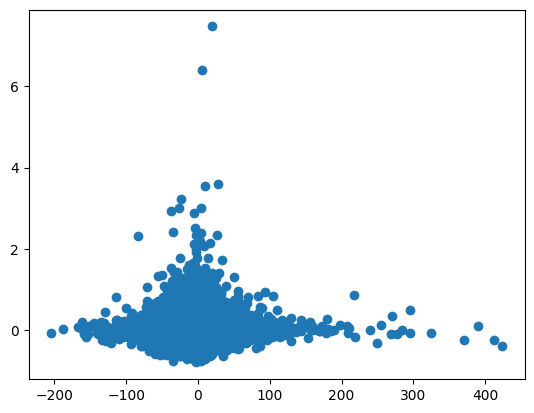

In [120]:
plt.scatter(x=pred_returns, y=pred_betas["RET"])
plt.show()

# Machine Learning

We will attempt implementign **PLS** as our machine learning method as it provides the most potent return capabilities as outlined in Lecture 4's code example, and in the ML slides.

In [ ]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import ParameterGrid

In [ ]:
# validation function
def validate_model(model_type, param_grid, x_train, y_train, x_validate, y_validate):
    # Special case for LinearRegression because it doesn't have hyperparameters to tune
    if model_type == LinearRegression:
        model = LinearRegression()
        model.fit(x_train, y_train)
        pred = model.predict(x_validate)
        r2 = r2_score(y_validate, pred)
        
        return r2
    else: # The other cases
        
        # Establishses the ParameterGrid
        model_param_grid = ParameterGrid(param_grid)
        
        # Initialize values
        best_MAE = 0
        best_r2 = 1
        best_config = None
        # Iterate through the parameter grid, fit models to the hyperparameters
        # and check for MAE and R2 values
        
        # each param_config in that validation function would represent 1 combination of the possible parameters.
        # for example in Lab 6, when I'm validating for the elastic net regression, I have 
        # 2 possible hyperparameters: alpha and l1_ratio. 
        #alpha can take on values 0.0001, 0.0005, etc, and l1_ratio can take on values 0, 1, 0.01. 
        #So each param_config in the for loop in validate_model would go over 1 possible 
        #combination of the hyperparameter and keep the one that gives us the best MAE/R2
        for param_config in model_param_grid:
            curr_config_MAEs = []
            model = model_type(**param_config)
            model.fit(x_train, y_train)
            pred = model.predict(x_validate)
            MAE = mean_squared_error(y_validate,pred)
            r2 = r2_score(y_validate, pred)
            curr_config_MAEs.append(MAE)
            if best_MAE == 0 or (MAE < best_MAE):
                best_MAE = MAE
                best_config = param_config
            if best_r2 == 1 or (r2 > best_r2):
                best_r2 = r2
        return best_config, best_MAE, best_r2

# Predictions
def pred(model_type, x_train, y_train, x_test, y_test):
    # Fit model and predict 
    model = model_type.fit(x_train, y_train)
    pred = model.predict(x_test)
    
    # Format prediction as DataFrame
    pred_df = pd.DataFrame(pred, columns = ['RET_pred'])
    pred_df.set_index(x_test.index, inplace = True)
    
    r2 = r2_score(y_test, pred)
    return pred_df, r2

In [ ]:
# using a 60/20/20 split
# train, validate, test = \
#                         np.split(all_monthly_data.sample(frac=1, random_state=42), 
#                         [int(.6*len(all_monthly_data)), int(.8*len(all_monthly_data))])

# No subset
train, validate, test = \
                        np.split(all_monthly_data,
                        [int(.6*len(all_monthly_data)), int(.8*len(all_monthly_data))])

x_train = train[model_factors + ["yyyymm", "permno"]].set_index(["yyyymm", "permno"])
y_train = train[['RET', "yyyymm", "permno"]].set_index(["yyyymm", "permno"])

x_validate = validate[model_factors + ["yyyymm", "permno"]].set_index(["yyyymm", "permno"])
y_validate = validate[['RET', "yyyymm", "permno"]].set_index(["yyyymm", "permno"])

x_test = test[model_factors + ["yyyymm", "permno"]].set_index(["yyyymm", "permno"])
y_test = test[['RET', "yyyymm", "permno"]].set_index(["yyyymm", "permno"])

In [ ]:
x_train

IM  range_20  log_vol_dollar_20  range_120  \
yyyymm   permno                                                      
198012.0 10145.0  0.374586  0.027456          15.617313   0.022920   
         10241.0  0.188068  0.018115          13.277532   0.019202   
         10460.0  0.324759  0.036155          13.062007   0.027327   
         10516.0  0.170149  0.031346          15.249913   0.031163   
         10866.0  0.273820  0.008009          11.612416   0.013282   
...                    ...       ...                ...        ...   
200812.0 44206.0 -0.256424  0.055367          17.200459   0.038970   
         44274.0 -0.299851  0.097975          15.410891   0.067219   
         44329.0 -0.282099  0.056087          16.510059   0.038861   
         44601.0 -0.282099  0.061162          17.503754   0.043618   
         44644.0 -0.282099  0.061832          18.744589   0.036077   

                  log_vol_dollar_120    xret_5   xret_10   xret_20  \
yyyymm   permno                                                      
198012.0 10145.0           15.145167 -0.045500 -0.051723 -0.032998   
         10241.0           13.227823 -0.033571 -0.063374 -0.141331   
         10460.0           12.680238  0.077472  0.109122  0.094566   
         10516.0           15.026468 -0.048646 -0.008587 -0.005626   
         10866.0           11.810300  0.002714 -0.027249 -0.088989   
...                              ...       ...       ...       ...   
200812.0 44206.0           17.022322 -0.053123  0.005273  0.104616   
         44274.0           15.254340  0.174990  0.091204  0.344395   
         44329.0           16.602987 -0.062214 -0.068661 -0.020760   
         44601.0           17.687756  0.037796 -0.016867 -0.031714   
         44644.0           18.627130  0.068823  0.138215  0.295415   

                  xret_indsize_20  xret_indsize_std20  ...        EP  \
yyyymm   permno                                        ...             
198012.0 10145.0        -0.103709            0.024948  ...  0.159071   
         10241.0        -0.036481            0.009797  ...  0.150070   
         10460.0         0.068687            0.029715  ...  0.077183   
         10516.0         0.084091            0.022241  ...  0.092024   
         10866.0        -0.020212            0.009537  ...  0.211710   
...                           ...                 ...  ...       ...   
200812.0 44206.0         0.038293            0.019833  ...  0.067112   
         44274.0         0.258588            0.039614  ...  0.054510   
         44329.0        -0.010352            0.023586  ...  0.012323   
         44601.0        -0.021307            0.016859  ...  0.063949   
         44644.0         0.305823            0.023754  ...  0.055050   

                        SP     roe_q     roa_q       Cto     pe_ttm  \
yyyymm   permno                                                       
198012.0 10145.0  3.106572  0.042556  0.015194  0.303363   6.286484   
         10241.0  7.809400  0.041306  0.008451  0.432945   6.663567   
         10460.0  1.424796  0.043730  0.022653  0.409445  12.956169   
         10516.0  2.103178  0.046955  0.026372  0.580968  10.866713   
         10866.0  5.921999  0.028797  0.016386  0.548834   4.723448   
...                    ...       ...       ...       ...        ...   
200812.0 44206.0  1.410528  0.025202  0.005829  0.118567  14.900494   
         44274.0  1.266940  0.021542  0.014311  0.253302  18.345311   
         44329.0  0.854643  0.021105  0.007056  0.120839  81.149296   
         44601.0  1.459469  0.028512  0.009361  0.257517  15.637459   
         44644.0  0.411552  0.054647  0.011713  0.091913  18.165453   

                  lag_log_size      10M2    volinc  recession_affinity  
yyyymm   permno                                                         
198012.0 10145.0      7.566481  0.013658  0.040110           60.164922  
         10241.0      6.345893  0.013658  0.009316           13.974516  
         10460.0      5.905587  0.013658  0.00768

In [ ]:
pls_grid = dict()
pls_grid['n_components'] = np.arange(1, len(model_factors)+1, 1)

pls_best_config, pls_best_MAE, pls_best_r2 = validate_model(PLSRegression, pls_grid, x_train, y_train, x_validate\
                                                            , y_validate)
print('Best config:' + str(pls_best_config))
print('Validation R2: ' + str(pls_best_r2))

Best config:{'n_components': 12}
Validation R2: 0.006075974149239438


In [ ]:
pls_pred_df, pls_test_r2 = pred(PLSRegression(pls_best_config['n_components']), x_train, y_train, x_test, y_test)

In [100]:
pls_pred_df.describe()

NameError: name 'pls_pred_df' is not defined

# Performance Analysis

In [ ]:
def total_ret(port_ret):
    return port_ret.sum()
    # return np.prod(port_ret + 1) - 1

def tracking_error(port_ret, bench_ret):
    return (port_ret - bench_ret).std()

def information_ratio(port_ret, bench_ret):
    return (total_ret(port_ret) - total_ret(bench_ret)) / tracking_error(port_ret, bench_ret)

def sharpe_ratio(port_ret, rf_ret):
    return information_ratio(port_ret, rf_ret)

def sharpe_ratio(port_xret):
    return total_ret(port_xret) / port_xret.std()

In [ ]:
# Write Permnos - for WRDS Queries

# with open("permnos.txt", "w") as file:
#     for permno in permnos:
#         file.write(f"{int(permno)},\n")